<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Practices/S09_NODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Ordinary Differential Equations

Источник: Mikhail Surtsukov github: <a href='https://github.com/msurtsukov/neural-ode/'>link</a>

Значительная доля процессов описывается дифференциальными уравнениями, это могут быть эволюция физической системы во времени, медицинское состояние пациента, фундаментальные характеристики фондового рынка и т.д. Данные о таких процессах последовательны и непрерывны по своей природе, в том смысле, что наблюдения - это просто проявления какого-то непрерывно изменяющегося состояния.

Есть также и другой тип последовательных данных, это дискретные данные, например, данные NLP задач. Состояния в таких данных меняется дискретно: от одного символа или слова к другому.

Сейчас оба типа таких последовательных данных обычно обрабатываются рекуррентными сетями, несмотря на то, что они отличны по своей природе, и похоже, требуют различных подходов.

На последней *NIPS-конференции* была представлена одна очень интересная статья, которая может помочь решить эту проблему. Авторы предлагают очень интересный подход, который они назвали **Нейронные Обыкновенные Дифференциальные Уравнения (Neural ODE)**.

В этом ноутбуке воспроизведены и кратко изложены результаты этой статьи, чтобы сделать знакомство с *ее идеей чуть* более простым.

## Постановка проблемы

Пусть есть процесс, который подчиняется некоторому неизвестному ОДУ и пусть есть несколько (зашумленных) наблюдений вдоль траектории процесса


$$
\frac{dz}{dt} = f(z(t), t) \tag{1}
$$
$$
\{(z_0, t_0),(z_1, t_1),...,(z_M, t_M)\} - \text{наблюдения}
$$

Как найти аппроксимацию $\widehat{f}(z, t, \theta)$ функции динамики $f(z, t)$?

Сначала рассмотрим более простую задачу: есть только 2 наблюдения, в начале и в конце траектории, $(z_0, t_0), (z_1, t_1)$.
Эволюция системы запускается из состояния $z_0, t_0$ на время $t_1 - t_0$ с какой-то параметризованной функцией динамики, используя любой метод эволюции систем ОДУ. После того, как система оказывается в новом состоянии $\hat{z_1}, t_1$, оно сравнивается с состоянием $z_1$ и разница между ними минимизируется варьированием параметров $\theta$ функции динамики.

Или, более формально, рассмотрим минимизацию функции потерь $L(\hat{z_1})$:

$$
L(z(t_1)) = L \Big( z(t_0) + \int_{t_0}^{t_1} f(z(t), t, \theta)dt \Big) = L \big( \text{ODESolve}(z(t_0), f, t_0, t_1, \theta) \big) \tag{2}
$$

<img src="https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/backprop.png?raw=true" width=600></img>
<p style="text-align: center">Картинка 1: Непрерывный *backpropagation* градиента требует решения аугментированного дифференциального уравнения назад во времени. <br /> Стрелки представляют корректировку распространенных назад градиентов градиентами от наблюдений.<br />
Иллюстрация из оригинальной статьи</p>

В случае, если вам лень лезть в математику, картинка выше дает довольно хорошее представление о том, что происходит.
Черная траектория олицетворяет решение ОДУ во время прохода вперед, а красная представляет решение сопряженного ОДУ во время бэкпропагейшена.

<img src="https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/Diff_solve.png?raw=true" width=1200></img>
Картинка 2: Несколько подходов к решению дифференциальных ОДУ
1. Обычный алгоритм обратного распространения ошибки. Сохраняет все значения градиентов и граф вычислений на каждом шаге, занимая очень много памяти
2. Схема с чекпоинтами. До точек с сохраненными значениями, которых меньше, чем в первом алгоритме. Расчеты по несохраненным точкам ведутся в прямом направлении при обратном распространении ошибки, что увеличивает количество вычислений.
3. Метод сопряженного уравнения, описанный в статье. Сохраняем только последнее значение градиента лосса в конце форвард прогонки, выигрывая по памяти. При обратном распространенни ошибки градиенты рассчитываются заново от последнего состояния, сильно увеличивая время расчетов. Также может расходится с прямым решением при проходе обратно.



Чтобы минимизировать $L$, нужно рассчитать градиенты по всем его параметрами: $z(t_0), t_0, t_1, \theta$. Чтобы сделать это, сначала нужно определить, как $L$ зависит от состояния в каждый момент времени $(z(t))$:
$$
a(t) = -\frac{\partial L}{\partial z(t)} \tag{3}
$$
$a(t)$ зовется *сопряженным* (*adjoint*) состоянием, его динамика задается другим дифференциальными уравнением, которое можно считать непрерывным аналогом дифференцирования сложной функции (*chain rule*):

$$
\frac{d a(t)}{d t} = -a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} \tag{4}
$$

Вывод этой формулы можно посмотреть в аппендиксе оригинальной статьи.

Векторы в этой статье следует считать строчными векторами, хотя оригинальная статья использует и строчное и столбцовое представление.

Решая диффур (4) назад во времени, получаем зависимость от начального состояния $z(t_0)$:

$$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt \tag{5}
$$

Чтобы рассчитать градиент по отношению к $t$ и $\theta$, можно просто считать их частью состояния. Такое состояние зовется *аугментированным*. Динамика такого состояния тривиально получается из оригинальной динамики:

$$
\frac{d}{dt} \begin{bmatrix} z \\ \theta \\ t \end{bmatrix} (t) = f_{\text{aug}}([z, \theta, t]) := \begin{bmatrix} f([z, \theta, t ]) \\ 0 \\ 1 \end{bmatrix} \tag{6}
$$

Тогда сопряженное состояние к этому аугментированному состоянию:

$$
a_{\text{aug}} := \begin{bmatrix} a \\ a_{\theta} \\ a_t \end{bmatrix}, a_{\theta}(t) := \frac{\partial L}{\partial \theta(t)}, a_t(t) := \frac{\partial L}{\partial t(t)} \tag{7}
$$

Градиент аугментированной динамики:

$$
\frac{\partial f_{\text{aug}}}{\partial [z, \theta, t]} = \begin{bmatrix}
\frac{\partial f}{\partial z} & \frac{\partial f}{\partial \theta} & \frac{\partial f}{\partial t} \\
0 & 0 & 0 \\
0 & 0 & 0
\end{bmatrix} \tag{8}
$$

Дифференциальное уравнение сопряженного аугментированного состояния из формулы (4) тогда:

$$
\frac{d a_{\text{aug}}}{dt} = - \begin{bmatrix} a\frac{\partial f}{\partial z} & a\frac{\partial f}{\partial \theta} & a\frac{\partial f}{\partial t}\end{bmatrix} \tag{9}
$$

Решение этого ОДУ назад во времени дает:

$$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt \tag{10}
$$

$$
\frac{\partial L}{\partial \theta} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial \theta} dt \tag{11}
$$

$$
\frac{\partial L}{\partial t_0} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} dt \tag{12}
$$

Что вместе с

$$
\frac{\partial L}{\partial t_1} = - a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} \tag{13}
$$

дает градиенты по всем входным параметрам в решатель ОДУ *ODESolve*.

Все градиенты (10), (11), (12), (13) могут быть рассчитаны вместе за один вызов *ODESolve* с динамикой сопряженного аугментированного состояния (9).

<img src="https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/pseudocode.png?raw=true" width=800></img>
<div align="center">Иллюстрация из оригинальной статьи</div>

Алгоритм выше описывает обратное распространения градиента решения ОДУ для последовательных наблюдений. Этот алгоритм реализует в себе все описанное выше.

В случае нескольких наблюдений на одну траекторию все рассчитывается так же, но в моменты наблюдений обратно распространенный градиент надо корректировать градиентами от текущего наблюдения, как показано в *иллюстрации 1*.

# Реализация

Код ниже - пример реализации **Нейронных ОДУ**. Впрочем, она очень близка к тому, что реализовано в [репозитории](https://github.com/rtqichen/torchdiffeq) у авторов статьи. Здесь содержится весь нужный для понимания код в одном месте, он также слегка более закомментированный. Для реального применения и экспериментов все же лучше использовать реализацию авторов оригинальной статьи.

In [ ]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

In [ ]:

use_cuda = torch.cuda.is_available()
use_cuda

True

Для начала надо реализовать любой метод эволюции систем ОДУ. В целях простоты здесь реализован метод Эйлера, хотя подойдет любой явный или неявный метод.

In [ ]:
def ode_solve(z0, t0, t1, f):
    """
    Простейший метод эволюции ОДУ - метод Эйлера
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

Здесь также описан суперкласс параметризованной функции динамики с парочкой полезных методов.

Во-первых: нужно возвращать все параметры от которых зависит функция в виде вектора.

Во-вторых: надо рассчитывать аугментированную динамику. Эта динамика зависит от градиента параметризованной функции по параметрам и входным данным. Чтобы не приходилось каждый раз для каждой новой архитектуры прописывать градиент руками, воспользуемся методом **torch.autograd.grad**.

In [ ]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # метод grad автоматически суммирует градиенты для всех элементов батча, надо expand их обратно
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

Код ниже описывает прямое и обратное распространение для *Нейронных ОДУ*. Приходится отделить этот код от основного ***torch.nn.Module*** в виде функции ***torch.autograd.Function*** потому, что в последнем можно реализовать произвольный метод обратного распространения, в отличие от модуля. Так что это просто костыль.

Эта функция лежит в основе всего подхода *Нейронных ОДУ*.

In [ ]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Динамика аугментированной системы, которую надо эволюционировать обратно во времени
        def augmented_dynamics(aug_z_i, t_i):
            """
            Тензоры здесь - это срезы по времени
            t_i - тензор с размерами: bs, 1
            aug_z_i - тензор с размерами: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # игнорируем параметры и время

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz для удобства
        with torch.no_grad():
            ## Создадим плейсхолдеры для возвращаемых градиентов
            # Распространенные назад сопряженные состояния, которые надо поправить градиентами от наблюдений
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # В отличие от z и p, нужно вернуть градиенты для всех моментов времени
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Рассчитаем прямые градиенты от наблюдений
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Подправим ими сопряженные состояния
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Упакуем аугментированные переменные в вектор
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Решим (эволюционируем) аугментированную систему назад во времени
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Распакуем переменные обратно из решенной системы
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Подправим сопряженное состояние в нулевой момент времени прямыми градиентами
            # Вычислим прямые градиенты
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Подправим
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

Теперь для удобства обернем эту функцию в **nn.Module**.

In [ ]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

# Применение

## *Восстановление* реальной функции динамики (проверка подхода)

В качестве базового теста проверим теперь, правда ли **Neural ODE** могут восстанавливать истинную функцию динамики, используя данные наблюдений.

Для этого мы сначала определим функцию динамики ОДУ, эволюционируем на ее основе траектории, а потом попробуем восстановить ее из случайно параметризованной функции динамики.

Для начала проверим простейший случай линейного ОДУ. Функция динамики это просто действие матрицы.

$$
\frac{dz}{dt} = \begin{bmatrix}-0.1 & -1.0\\1.0 & -0.1\end{bmatrix} z
$$

Обучаемая функция параметризована случаной матрицей.

![learning gif](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/linear_learning.gif?raw=true)

Далее чуть более изощренная динамика (без гифки, потому что процесс обучения не такой красивый :))  
Обучаемая функция здесь это полносвязная сеть с одним скрытам слоем.
![complicated result](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/comp_result.png?raw=true)

Далее код этих примеров (спойлер)

In [ ]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, # your code here)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

Функция динамики это просто матрица

In [ ]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

Случайно параметризованная матрица

In [ ]:
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

Динамика для более изощренных траекторий

In [ ]:
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

Обучаемая динамика в виде полносвязной сети

In [ ]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant  # нужен будет при РНН+НОДЕ

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [ ]:
def to_np(x):
    return x.detach().cpu().numpy()

In [ ]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None:
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [ ]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int64)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"imgs/{name}/{i}.png")
            clear_output(wait=True)

In [ ]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

In [ ]:
!mkdir imgs

In [ ]:
!mkdir imgs/linear

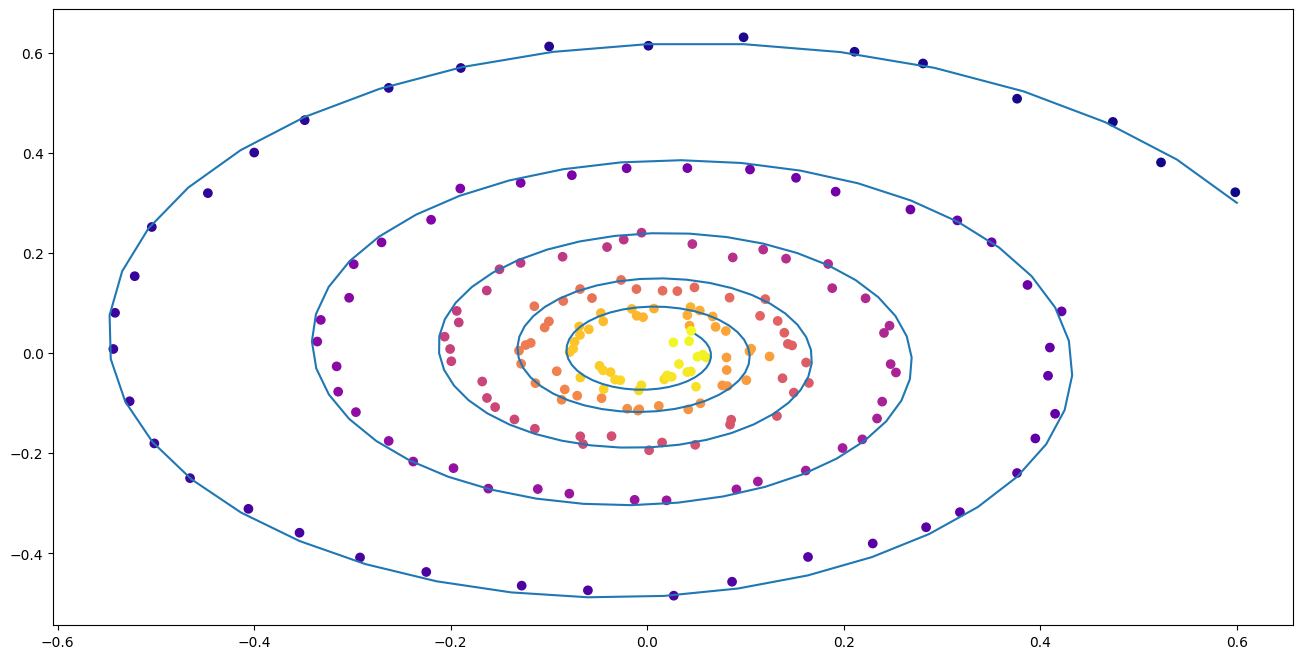

In [ ]:
conduct_experiment(ode_true, ode_trained, 500, "linear")

In [ ]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

In [ ]:
!mkdir imgs/comp

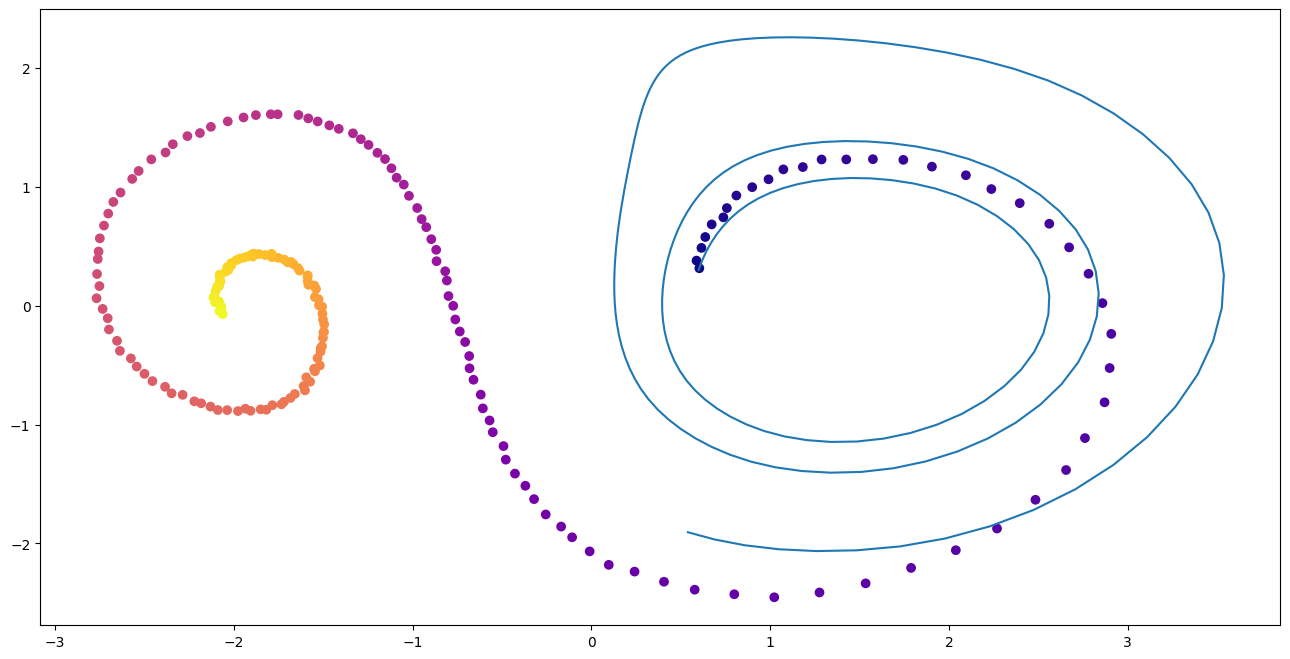

In [ ]:
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)

Как можно видеть, *Neural ODE* довольно хорошо справляются с восстановлением динамики. То есть концепция в целом работает.  
Теперь проверим на чуть более сложной задаче (MNIST, ха-ха).

## Neural ODE вдохновленные ResNets

В ResNet'ax скрытое состояние меняется по формуле
$$
h_{t+1} = h_{t} + f(h_{t}, \theta_{t})
$$

где $t \in \{0...T\}$ - это номер блока и $f$ это функция выучиваемая слоями внутри блока.

В пределе, если брать бесконечное число блоков со все меньшими шагами, мы получаем непрерывную динамику скрытого слоя в виде ОДУ, прямо как то, что было выше.

$$
\frac{dh(t)}{dt} = f(h(t), t, \theta)
$$

Начиная со входного слоя $h(0)$, мы можем определить выходной слой $h(T)$ как решение этого ОДУ в момент времени T.

Теперь мы можем считать $\theta$ как распределенные (*shared*) параметры между всеми бесконечно малыми блоками.

<img src="https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/Pre_ResNET.png?raw=true" width=1200></img>

Два варианта архитектуры ResNET. Как раз вторая схема крайне напоминает метод Эйлера.

<img src="https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/ResNet_w_NODE.png?raw=true" width=600></img>


Эволюция системы на архитектуре ResNET и с NODE

### Проверка Neural ODE архитектуры на MNIST

В этой части мы проверим возможность *Neural ODE* быть использованными в виде компонентов в более привычных архитектурах.

В частности, мы заменим остаточные (*residual*) блоки на *Neural ODE* в классификаторе MNIST.

<img src="https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/mnist_example.png?raw=true" width=400></img>

Код ниже (спойлер)

In [ ]:
def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

In [ ]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [ ]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [ ]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37441563.56it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1113348.84it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9524473.15it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9558719.90it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [ ]:
print(torchvision.__version__)

0.17.1+cu121


In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [ ]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [ ]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


<ipython-input-31-21ca1da03176>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 18.660%
Training Epoch 1...


<ipython-input-30-7bd42b6f5b96>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.15699
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.880%
Training Epoch 2...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.04983
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.060%
Training Epoch 3...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03760
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.920%
Training Epoch 4...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03029
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.270%
Training Epoch 5...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.02403
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 99.270%


<Axes: title={'center': 'train error'}, xlabel='cum_data'>

<Figure size 900x500 with 0 Axes>

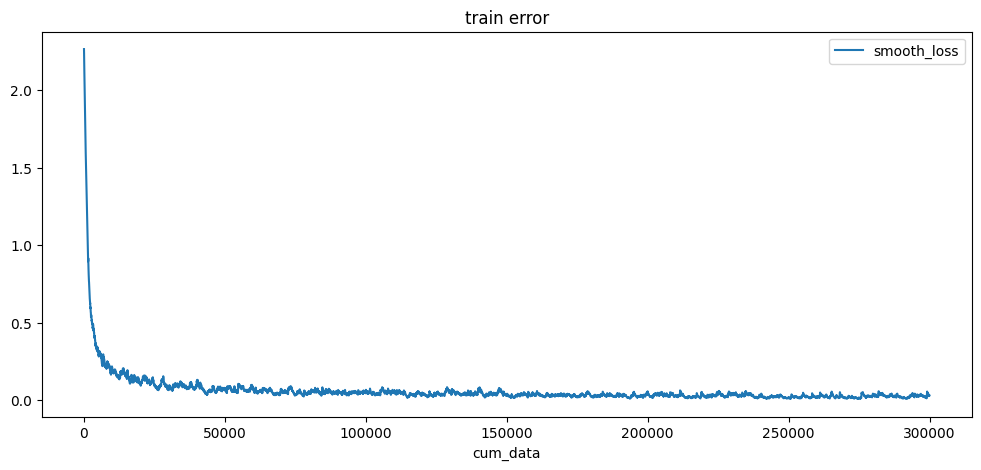

In [ ]:
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

```
Testing...
100% 79/79 [00:01<00:00, 45.69it/s]
Test Accuracy: 9.740%

Training Epoch 1...
100% 1875/1875 [01:15<00:00, 24.69it/s]
Train loss: 0.20137
Testing...
100% 79/79 [00:01<00:00, 46.64it/s]
Test Accuracy: 98.680%

Training Epoch 2...
100% 1875/1875 [01:17<00:00, 24.32it/s]
Train loss: 0.05059
Testing...
100% 79/79 [00:01<00:00, 46.11it/s]
Test Accuracy: 97.760%

Training Epoch 3...
100% 1875/1875 [01:16<00:00, 24.63it/s]
Train loss: 0.03808
Testing...
100% 79/79 [00:01<00:00, 45.65it/s]
Test Accuracy: 99.000%

Training Epoch 4...
100% 1875/1875 [01:17<00:00, 24.28it/s]
Train loss: 0.02894
Testing...
100% 79/79 [00:01<00:00, 45.42it/s]
Test Accuracy: 99.130%

Training Epoch 5...
100% 1875/1875 [01:16<00:00, 24.67it/s]
Train loss: 0.02424
Testing...
100% 79/79 [00:01<00:00, 45.89it/s]
Test Accuracy: 99.170%
```

![train error](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/train_error.png?raw=true)

После очень грубой тренировки в течение всего 5 эпох и 6 минут обучения, модель уже достигла тестовой ошибки в менее, чем 1%. Можно сказать, что *Нейронные ОДУ* хорошо интегрируются *в виде* компонента в более традиционные сети.

В своей статье авторы также сравнивают этот классификатор (ODE-Net) с обычной полнозвязной сетью, с ResNet'ом с похожей архитектурой, и с точно такой же архитектурой, только в которой градиент распространяется напрямую через операции в *ODESolve* (без метода сопряженного градиента) (RK-Net).

!["Methods comparison"](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/methods_compare.png?raw=true)
<div align="center">Иллюстрация из оригинальной статьи</div>

Согласно им, 1-слойная полносвязноая сеть с примерно таким же количеством параметров как *Neural ODE* имеет намного более высокую ошибку на тесте, ResNet с примерно такой же ошибкой имеет намного больше параметров, а RK-Net без метода сопряженного градиента, имеет чуть более высокую ошибку и с линейно растущим потреблением памяти (чем меньше допустимая ошибка, тем больше шагов должен сделать *ODESolve*, что линейно увеличивает потребляемую память с числом шагов).

Авторы в своей имплементации используют неявный метод Рунге-Кутты с адаптивным размером шага, в отличие от простейшего метода Эйлера здесь. Они также изучают некоторые свойства новой архитектуры.

!["Node attrs"](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/ode_solver_attrs.png?raw=true)

<div align="center">Характеристика ODE-Net (NFE Forward - количество вычислений функции при прямом проходе)</div>
<div align="center">Иллюстрация из оригинальной статьи</div>

- (a) Изменение допустимого уровня численной ошибки изменяет количество шагов в прямое распространении.
- (b) Время потраченное на прямоу распространение пропорционально количеству вычеслений функции.
- (c) Количество вычислений функции при обратном распространение составляет примерно половину от прямого распространения, это указывает на то, что метод сопряженного градиента может быть более вычислительно эффективным, чем распространение градиента напрямую через *ODESolve*.
- (d) Как ODE-Net становится все более и более обученным, он требует все больше вычислений функции (все меньший шаг), возможно адаптируясь под восрастающую сложность модели.

## Скрытая генеративная функция для моделирования временного ряда

Neural ODE подходит для обработки непрерывных последовательных данных и тогда, когда траектория лежит в неизвестном скрытом пространстве.

В этом разделе мы поэкспер*и*ментируем в генерации непрерывных последовательностей, используя *Neural ODE*, и немножко посмотрим на выученное скрытое пространство.

Авторы также сравнивают это с аналогичными последовательност*ями*, сгенерированными Рекуррентными сетями.

Эксперимент здесь слегка отличается от соответствующего примера в репозитории авторов, здесь более разнообразное множество траекторий.

### Данные

Обучающие данные состоят из случайных спиралей, половина из которых направлены по-часовой, а вторая - против часовой. Далее случайные подпоследовательности сэмплируются из этих спиралей, обрабатываются кодирующей рекуррентной моделью в обратном направлении, порождая стартовое скрытое состояние, которое затем эволюционирует, создавая траекторию в скрытом пространстве. Это скрытая траектория затем отображается в пространство данных и сравнивается с сэмплированной подпоследовательностью. Таким образом, модель учится генерировать траектории, похожие на датасет.

![image.png](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/spirals_examples.png?raw=true)
<div align="center">Примеры спиралей из датасета</div>

### VAE как генеративная модель

Генеративная модель через процедуру сэмплирования:
$$
z_{t_0} \sim \mathcal{N}(0, I)
$$

$$
z_{t_1}, z_{t_2},...,z_{t_M} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_M)
$$

$$
x_{t_i} \sim p(x \mid z_{t_i};\theta_x)
$$

Которая может быть обучена, используя подход вариационных автокодировщиков.

1. Пройтись рекуррентным энкодером через временную последовательность назад во времени, чтобы получить параметры $\mu_{z_{t_0}}$, $\sigma_{z_{t_0}}$ вариационного апестериорного распределения, а потом сэмплировать из него:
$$
z_{t_0} \sim q \left( z_{t_0} \mid x_{t_0},...,x_{t_M}; t_0,...,t_M; \theta_q \right) = \mathcal{N} \left(z_{t_0} \mid \mu_{z_{t_0}} \sigma_{z_{t_0}} \right)
$$
2. Получить скрытую траекторию:
$$
z_{t_1}, z_{t_2},...,z_{t_N} = \text{ODESolve}(z_{t_0}, f, \theta_f, t_0,...,t_N), \text{ где } \frac{d z}{d t} = f(z, t; \theta_f)
$$
3. Отобразить скрытую траекторию в траекторию в данных, используя другую нейросеть: $\hat{x_{t_i}}(z_{t_i}, t_i; \theta_x)$
4. Максимизировать оценку нижней границы обоснованности (ELBO) для сэмплированной траектории:
$$
\text{ELBO} \approx N \Big( \sum_{i=0}^{M} \log p(x_{t_i} \mid z_{t_i}(z_{t_0}; \theta_f); \theta_x) + KL \left( q( z_{t_0} \mid x_{t_0},...,x_{t_M}; t_0,...,t_M; \theta_q) \parallel \mathcal{N}(0, I) \right) \Big)
$$
И в случае Гауссовского апостериорного распределения $p(x \mid z_{t_i};\theta_x)$ и известного уровня шума $\sigma_x$:
$$
\text{ELBO} \approx -N \Big( \sum_{i=1}^{M}\frac{(x_i - \hat{x_i} )^2}{\sigma_x^2} - \log \sigma_{z_{t_0}}^2 + \mu_{z_{t_0}}^2 + \sigma_{z_{t_0}}^2 \Big) + C
$$

Граф вычислений скрытой ОДУ модели можно изобразить вот так
![vae_model](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/vae_model.png?raw=true)
<div align="center">Иллюстрация из оригинальной статьи</div>

<img src="https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/gru.png?raw=true" width=650></img>

Немного измененный вид

Эту модель можно затем протестировать на то, как она интерполирует траекторию, используя только начальные наблюдения.

Код ниже (спойлер)

### Define models

In [ ]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.rnn = nn.GRU(input_dim+1, hidden_dim)
        self.hid2lat = nn.Linear(hidden_dim, 2*latent_dim)

    def forward(self, x, t):
        # Concatenate time to input
        t = t.clone()
        t[1:] = t[:-1] - t[1:]
        t[0] = 0.
        xt = torch.cat((x, t), dim=-1)

        _, h0 = self.rnn(xt.flip((0,)))  # Reversed
        # Compute latent dimension
        z0 = self.hid2lat(h0[0])
        z0_mean = z0[:, :self.latent_dim]
        z0_log_var = z0[:, self.latent_dim:]
        return z0_mean, z0_log_var

In [ ]:
class NeuralODEDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        func = NNODEF(latent_dim, hidden_dim, time_invariant=True)
        self.ode = NeuralODE(func)
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, z0, t):
        zs = self.ode(z0, t, return_whole_sequence=True)

        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs

In [ ]:
class ODEVAE(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim)
        self.decoder = NeuralODEDecoder(output_dim, hidden_dim, latent_dim)

    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t)
        if MAP:
            z = z_mean
        else:
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var)
        x_p = self.decoder(z, t)
        return x_p, z, z_mean, z_log_var

    def generate_with_seed(self, seed_x, t):
        seed_t_len = seed_x.shape[0]
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len])
        x_p = self.decoder(z_mean, t)
        return x_p

### Генерация датасета

In [ ]:
t_max = 6.29*5
n_points = 200
noise_std = 0.02

num_spirals = 1000

index_np = np.arange(0, n_points, 1, dtype=int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

# Generate random spirals parameters
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 =  1.0 * normal01.sample((num_spirals,)).abs()

xs_list = []
for i in range(num_spirals):
    if i % 2 == 1: #  Make it counter-clockwise
        W21, W12 = W12, W21

    func = LinearODEF(Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times

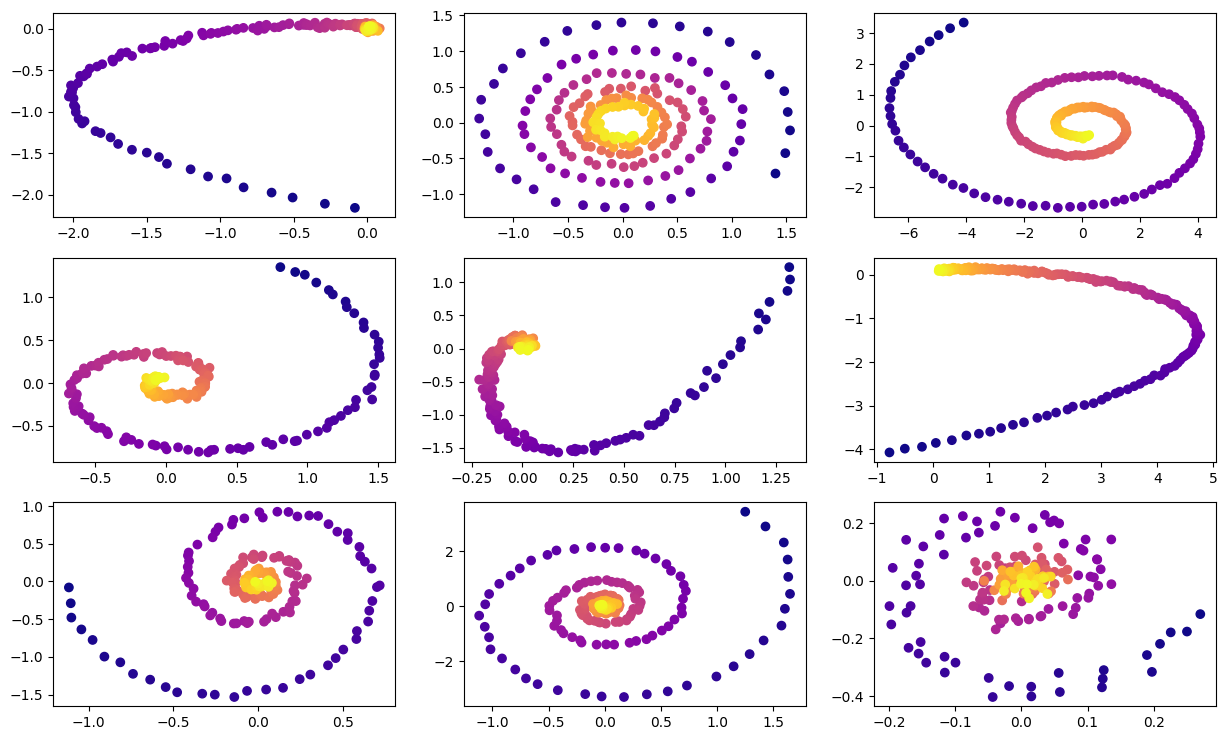

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, i, 0], samp_trajs[:, i, 1], c=samp_ts[:, i, 0], cmap=cm.plasma)
plt.show()

In [ ]:
import numpy.random as npr

def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]
    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            t0_idx = npr.multinomial(1, [1. / (time_len - n_sample)] * (time_len - n_sample))
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size*i, batch_size*(i+1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]

### Обучение

In [ ]:
vae = ODEVAE(2, 64, 6)
vae = vae.cuda()
if use_cuda:
    vae = vae.cuda()

In [ ]:
optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.001)

In [ ]:
preload = False
n_epochs = 20000
batch_size = 100

plot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_obs = samp_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_ts = samp_ts[:, plot_traj_idx:plot_traj_idx+1]
if use_cuda:
    plot_traj = plot_traj.cuda()
    plot_obs = plot_obs.cuda()
    plot_ts = plot_ts.cuda()

if preload:
    vae.load_state_dict(torch.load("models/vae_spirals.sd"))

for epoch_idx in range(n_epochs):
    losses = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
        optim.zero_grad()
        if use_cuda:
            x, t = x.cuda(), t.cuda()

        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]

        x_p, z, z_mean, z_log_var = vae(x, t)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        loss = 0.5 * ((x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= max_len
        loss.backward()
        optim.step()
        losses.append(loss.item())

    print(f"Epoch {epoch_idx}")

    frm, to, to_seed = 0, 200, 50
    seed_trajs = samp_trajs[frm:to_seed]
    ts = samp_ts[frm:to]
    if use_cuda:
        seed_trajs = seed_trajs.cuda()
        ts = ts.cuda()

    samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.scatter(to_np(seed_trajs[:, i, 0]), to_np(seed_trajs[:, i, 1]), c=to_np(ts[frm:to_seed, i, 0]), cmap=cm.plasma)
        ax.plot(to_np(orig_trajs[frm:to, i, 0]), to_np(orig_trajs[frm:to, i, 1]))
        ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
    plt.show()

    print(np.mean(losses), np.median(losses))
    clear_output(wait=True)

KeyboardInterrupt: 

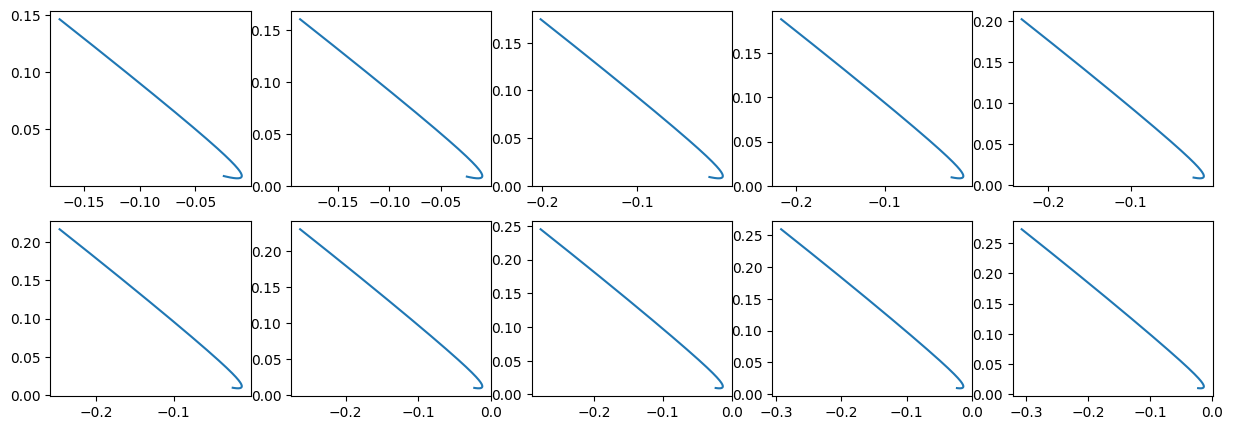

In [ ]:
spiral_0_idx = 3
spiral_1_idx = 6

homotopy_p = Tensor(np.linspace(0., 1., 10)[:, None])
vae = vae
if use_cuda:
    homotopy_p = homotopy_p.cuda()
    vae = vae.cuda()

spiral_0 = orig_trajs[:, spiral_0_idx:spiral_0_idx+1, :]
spiral_1 = orig_trajs[:, spiral_1_idx:spiral_1_idx+1, :]
ts_0 = samp_ts[:, spiral_0_idx:spiral_0_idx+1, :]
ts_1 = samp_ts[:, spiral_1_idx:spiral_1_idx+1, :]
if use_cuda:
    spiral_0, ts_0 = spiral_0.cuda(), ts_0.cuda()
    spiral_1, ts_1 = spiral_1.cuda(), ts_1.cuda()

z_cw, _ = vae.encoder(spiral_0, ts_0)
z_cc, _ = vae.encoder(spiral_1, ts_1)

homotopy_z = z_cw * (1 - homotopy_p) + z_cc * homotopy_p

t = torch.from_numpy(np.linspace(0, 6*np.pi, 200))
t = t[:, None].expand(200, 10)[:, :, None].cuda()
t = t.cuda() if use_cuda else t
hom_gen_trajs = vae.decoder(homotopy_z, t)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.plot(to_np(hom_gen_trajs[:, i, 0]), to_np(hom_gen_trajs[:, i, 1]))
plt.show()

In [ ]:
#torch.save(vae.state_dict(), "models/vae_spirals.sd")

Вот что получается после ночи обучения
![spiral reconstruction with seed](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/spirals_reconstructed.png?raw=true)
<div align="center"> Точки - это зашумленные наблюдения оригинальной траектории (синий), <br /> желтая - это реконструированная и интерполированная траектория, используя точки как входы. <br /> Цвет точки показывает время. </div>

Реконструкции некоторых примеров не выглядят слишком хорошими. Может модель недостаточно сложная или недостаточно долго училась. В любом случае реконструкции выглядят очень разумно.

Теперь посмотрим что будет, если интерполировать скрытую переменную по-часовой траектории к противо-часовой траектории.
![homotopy](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/spirals_homotopy.png?raw=true)

Авторы также сравнивают реконструкции и интерполяции траекторий между *Neural ODE* и простой Рекуррентной сетью.
![ode_rnn_comp](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/ode_rnn_comp.png?raw=true)
<div align="center">Иллюстрация из оригинальной статьи</div>

## Непрерывные Нормализующие Потоки

Оригинальная статья также привносит многое в тему Нормализующих Потоков. Нормализующие потоки используются, когда нужно сэмплировать из некоторого сложного распределения, появившегося через замену переменных от некоторого простого распределения (Гауссовского, например), и при этом все еще знать плотность вероятности в точке каждого сэмпла.
Авторы показывают, что использование непрерывной замены переменных намного более вычислительно эффективно и интерпретируемо, чем предыдущие методы.

*Нормализующие потоки* очень полезны в таких моделях как *Вариационные Автокодировщики*, *Байесовские Нейронные Сети* и других из Баейсовского подхода.

Эта тема, впрочем, лежит за пределами *данной* статьи, и тем, кто заинтересовался, следует прочесть оригинальную научную статью.

Для затравки:
![CNF_NF_comp](https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/CNF_NF_comp.png?raw=true)

<div align="center">Визуализация трансформации из шума (простого распределения) в данные (сложное распределение) для двух датасетов; <br /> Ось-X показывает трансформацию плотности и сэмплов с течением "времени" (для ННП) и "глубины" (для НП). <br />Иллюстрация из оригинальной статьи</div>

<img src="https://github.com/Existanze54/sirius-neural-networks-2024/blob/main/Images/Continious_flows.png?raw=true" width=600></img>

Нормализующие потоки на гауссиане

# Полезные ссылки

   - [Оригинальная статья](https://arxiv.org/abs/1806.07366)
   - [Авторский репозиторий](https://github.com/rtqichen/torchdiffeq)
   - [Вариационный вывод](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf)
   - [Статья про VAE (Русский)](https://habr.com/en/post/331552/)
   - [Объяснение VAE](https://www.jeremyjordan.me/variational-autoencoders/)
   - [Больше про нормализующие потоки](http://akosiorek.github.io/ml/2018/04/03/norm_flows.html)
   - [Variational Inference with Normalizing Flows Paper](https://arxiv.org/abs/1505.05770)